In [3]:
import os
import numpy as np
from motion_planning.utils import parse_arguments, GIBSON_ROOT
import matplotlib.pyplot as plt

In [4]:
perception_name = 'rgb_model_v1'

In [ ]:
dataset_dir = os.path.join(GIBSON_ROOT, perception_name, 'mujoco_latents')
dataset_files = os.listdir(dataset_dir)

latents, camera_distances, azimuths, elevations, cup_ids, target_coords = np.load(os.path.join(dataset_dir, dataset_files[0]))
latents = latents[:, 0, :]



array([7, 7, 7, ..., 8, 8, 8])

In [6]:
def return_camera_specific_indices(camera_distance, azimuth, elevation):
    indices = (camera_distances == camera_distance)
    indices = indices * (azimuths == azimuth)
    indices = indices * (elevations == elevation)
    return indices

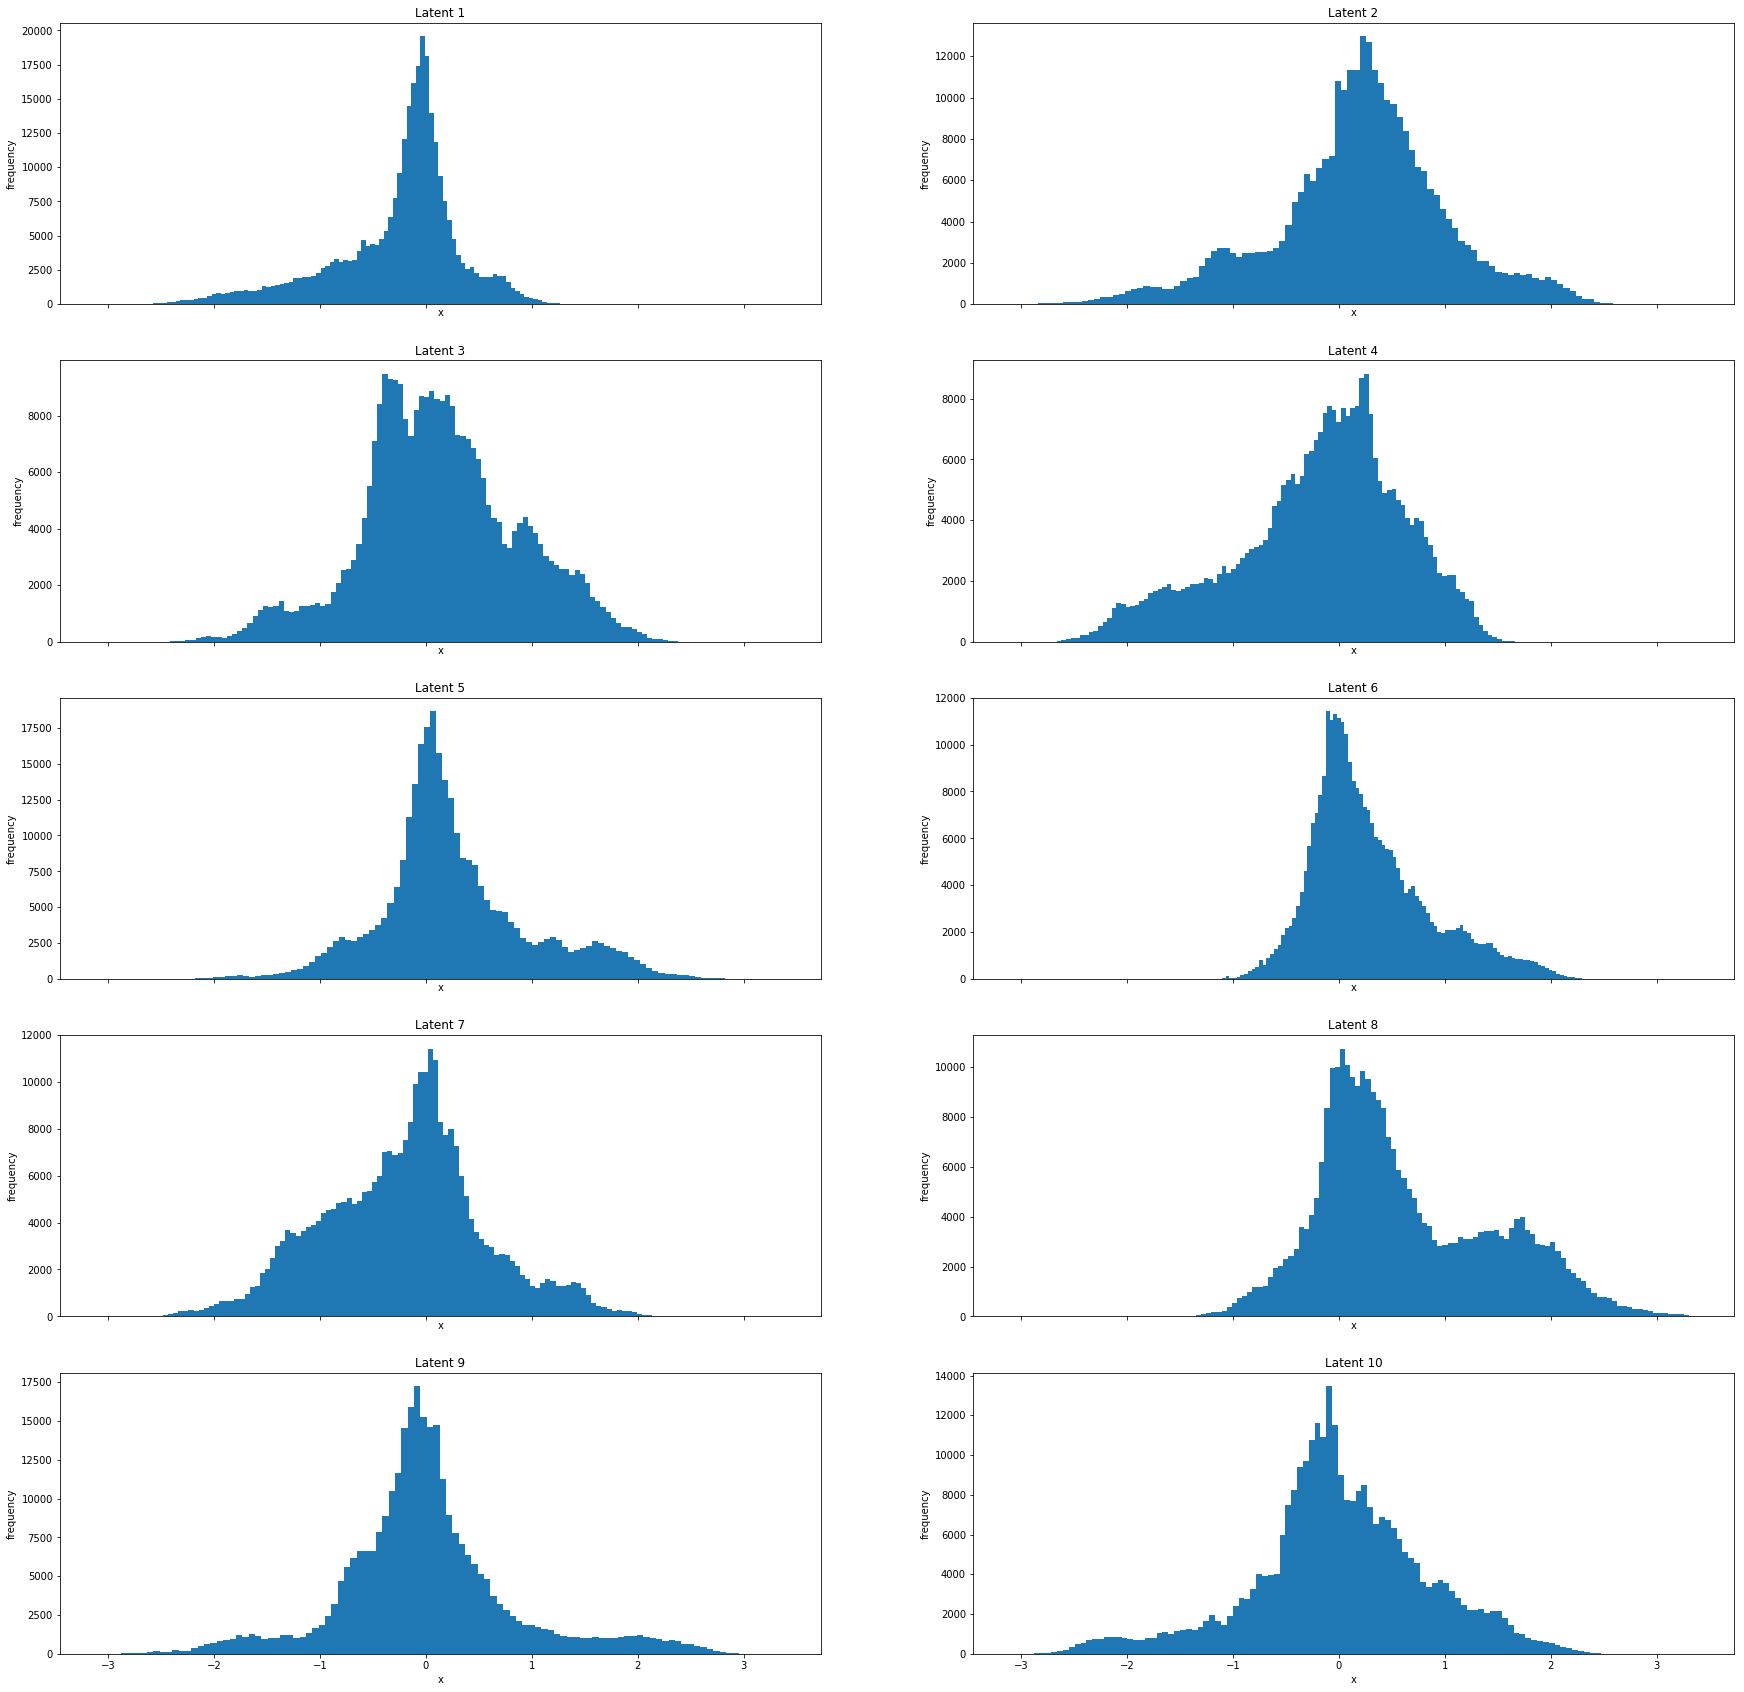

In [7]:
fig, axes = plt.subplots(latents.shape[1] / 2, 2, sharex=True, figsize=[30, 30])
for i in range(latents.shape[1]):
    ax = axes[int(i/2)][i%2]
    batch = latents[:, i]
    ax.hist(batch, bins=100)
    ax.set_title('Latent {}'.format(i + 1))
    ax.set_xlabel('x')
    ax.set_ylabel('frequency')

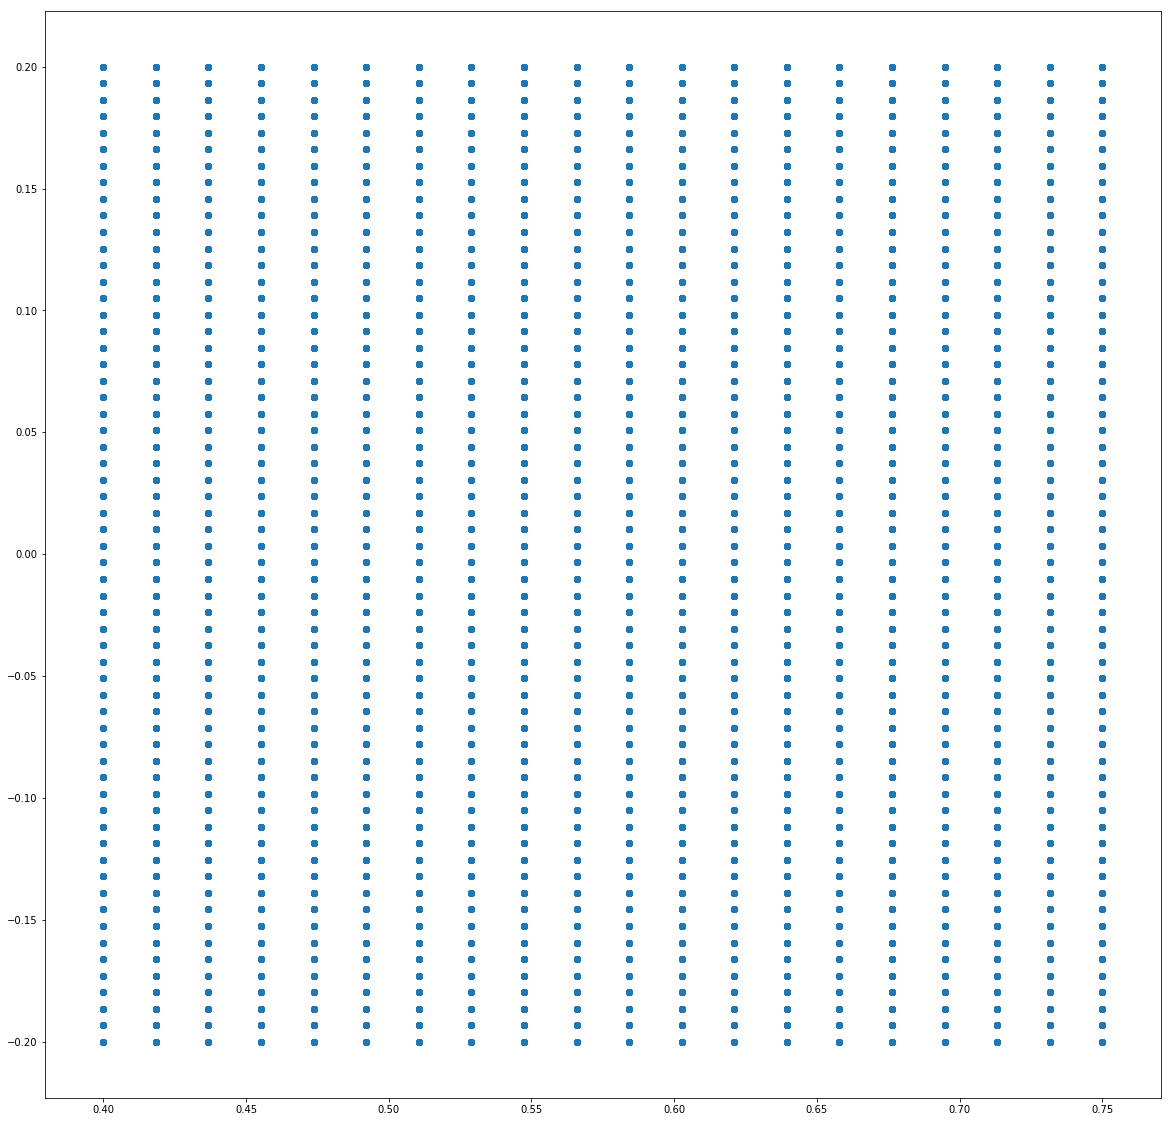

In [8]:

plt.figure(figsize=(20, 20))
plt.scatter(target_coords[:,0], target_coords[:,1])

In [9]:
print('Dataset error: ')
print(np.linalg.norm(target_coords[0] - target_coords[1]))
print(np.linalg.norm(target_coords[0] - target_coords[70]))

Dataset error: 
0.006779661016949157
0.07025464775037596


In [10]:
# perception_test.py
X_LIMITS = [0.4, 0.75]
Y_LIMITS = [-0.20, 0.20]


def get_centers_indices(poses, steps, x_divide, y_divide):
    
    if (x_divide):
        X_C = np.linspace(X_LIMITS[0], X_LIMITS[1], 2 + steps)
    else:
        X_C = np.linspace(X_LIMITS[0], X_LIMITS[1], 2 + 1)
    
    X_C = X_C[1:-1]
    
    if (y_divide):
        Y_C = np.linspace(Y_LIMITS[0], Y_LIMITS[1], 2 + steps)
    else:
        Y_C = np.linspace(Y_LIMITS[0], Y_LIMITS[1], 2 + 1)
        
    Y_C = Y_C[1:-1]
    
    center_indices = []
    for y in Y_C:
        for x in X_C:
            center_indices.append(np.argmin(np.linalg.norm(poses[:, :2] - np.array((x, y)), axis=1)))    
    return np.array(center_indices)

In [11]:

def create_clusters(pose_results, latents, steps, x_divide=True, y_divide=True):

    indices = get_centers_indices(pose_results, steps, x_divide, y_divide)
    
    num_samples = latents.shape[0]
    
    center_dists = np.zeros((indices.shape[0], num_samples))
    
    for idx in range(indices.shape[0]):
        
        center_dists[idx] = np.linalg.norm(latents - latents[indices[idx]], axis=1)

    labels = np.argmin(center_dists, axis=0)

    plt.figure(figsize=(5, 10))

    for idx in range(indices.shape[0]):
        labeled_end_poses = pose_results[(labels == idx)]
        plt.scatter(labeled_end_poses[:,0], labeled_end_poses[:,1])
        
    title = "The number of clusters {}".format(indices.shape[0])
    
    if (x_divide):
        title += " x axis dividided"
        
    if (y_divide):
        title += " y axis dividided"
        
    plt.title(title)
    
    return labels

array([0, 0, 0, ..., 1, 1, 1])

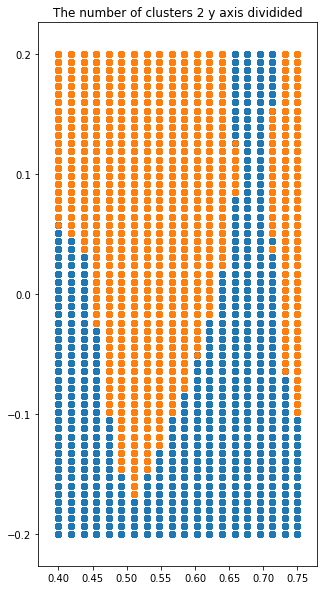

In [14]:
# y divided

create_clusters(target_coords, latents, 2, x_divide=False, y_divide=True)

array([1, 1, 3, ..., 0, 1, 1])

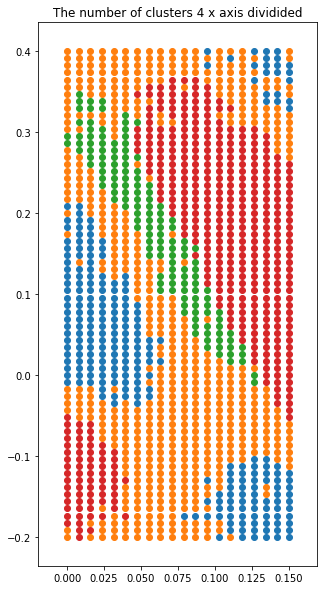

In [41]:
# X divided:
create_clusters(target_coords, latents, 4, x_divide=True, y_divide=False)

array([3, 3, 3, ..., 3, 3, 0])

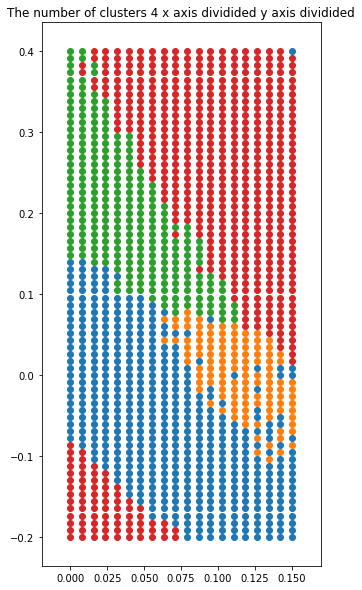

In [42]:
# X divided:
create_clusters(target_coords, latents, 2, x_divide=True, y_divide=True)

In [15]:
# from sklearn.cluster import KMeans
from sklearn.cluster import KMeans


def kmean_clustering(coords, latents, num_clusters):
    
    clf = KMeans(n_clusters=num_clusters, n_init=100)
    labels = clf.fit_predict(latents)
    
    plt.figure(figsize=(5, 10))

    for idx in range(num_clusters):
        labeled_end_poses = coords[(labels == idx)]
        plt.scatter(labeled_end_poses[:,0], labeled_end_poses[:,1])
        
    title = "KMEAN clustering with k {}".format(num_clusters)        
    plt.title(title)    
    
    return labels

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

def kmean_clustering_3D(coords, latents, shape_labels, num_clusters):
    
    clf = KMeans(n_clusters=num_clusters, n_init=100)
    cluster_labels = clf.fit_predict(latents)
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    
    for idx in range(num_clusters):
        cluster_indices = (cluster_labels == idx)
        labeled_end_poses = coords[cluster_indices]
        ax.scatter(labeled_end_poses[:,0], labeled_end_poses[:,1], shape_labels[cluster_indices])
        
    title = "KMEAN clustering with k {}".format(num_clusters)        
    
    #plt.title(title)    
    
    return cluster_labels

((150000, 2), (150000, 10))


array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

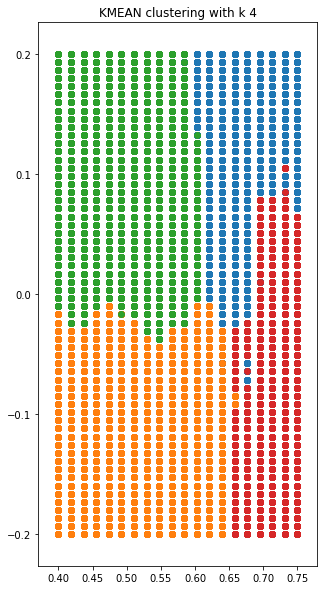

In [38]:
fixed_cup_id = (cup_ids == 7)


# KDMean:
t_coords = target_coords[fixed_cup_id, :]
t_latents = latents[fixed_cup_id]

print(t_coords.shape, t_latents.shape)
kmean_clustering(t_coords, t_latents, 4)

array([2, 2, 1, ..., 2, 2, 2], dtype=int32)

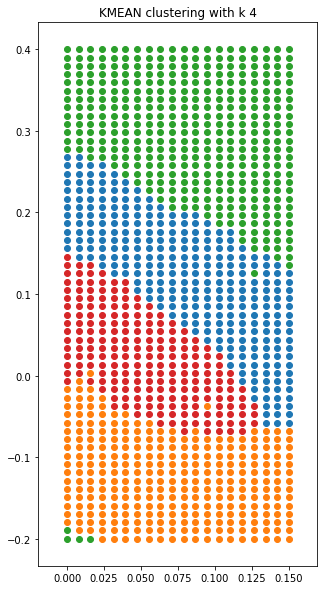

In [17]:
indices = return_camera_specific_indices(camera_distances[-1], azimuths[1], elevations[-1])

# KDMean:
kmean_clustering(target_coords[indices], latents[indices], 4)

In [69]:
dataset_files = os.listdir(dataset_dir)

latents, camera_distances, azimuths, elevations, cup_ids, target_coords = np.load(os.path.join(dataset_dir, dataset_files[0]))
latents = latents[:, 0, :]
fixed_camera_indices = return_camera_specific_indices(camera_distances[-1], azimuths[1], elevations[-1])

latents = [latents[fixed_camera_indices]]
cup_ids = [cup_ids[fixed_camera_indices]]
target_coords = [target_coords[fixed_camera_indices]]

for i in range(1, 3):
    data = np.load(os.path.join(dataset_dir, dataset_files[i]))
    latents.append(data[0][fixed_camera_indices, 0, :])
    cup_ids.append(data[4][fixed_camera_indices])
    target_coords.append(data[-1][fixed_camera_indices])

latents = np.concatenate(latents)
cup_ids = np.concatenate(cup_ids)
target_coords = np.concatenate(target_coords)


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

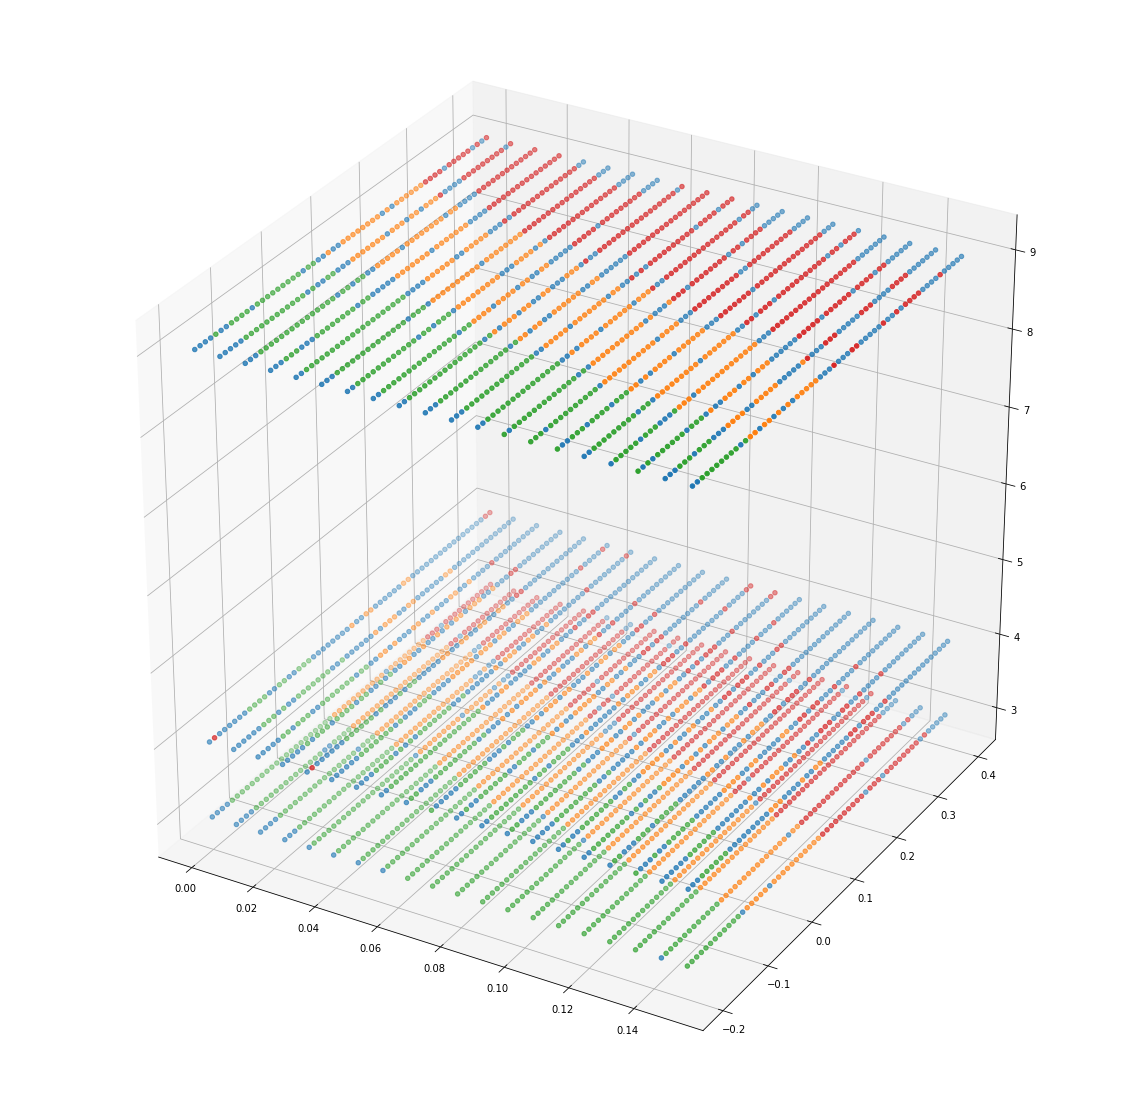

In [71]:
kmean_clustering_3D(target_coords, latents, cup_ids, 4)

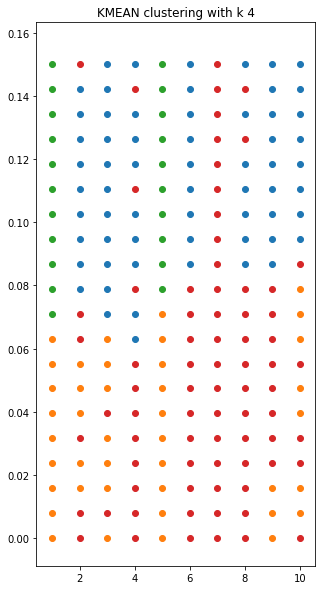

In [66]:
target_indices = target_coords[0, 1] == target_coords[:, 1]

target = np.stack([cup_ids[target_indices], target_coords[target_indices, 0]], 1)

asd = kmean_clustering(target, latents[target_indices], 4)